In [1]:
import seaborn as sns
import scipy as sp
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

wines = pd.read_csv('winequality-red.csv')
wines.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [2]:
#Reducing the number of quality classes from 6 to 3 to make classification easier
wines_copy = wines.copy()

conditions = [
    wines_copy["quality"]>=7,
    (wines_copy["quality"]>=5) & (wines_copy["quality"]<7),
    (wines_copy["quality"]<5)
]

values = [2,1,0]
wines_copy["simple_quality"] = np.select(conditions, values)
wines_copy.drop("quality", axis = 1, inplace = True)

In [3]:
#Balancing Classes
X = wines_copy.drop("simple_quality", axis = 1)
y = wines_copy["simple_quality"]

ros = RandomOverSampler(random_state= 42)
X_res, y_res = ros.fit_resample(X, y)
X_new = pd.concat([X_res,y_res],axis = 1)

Accuracy Score : 
0.9617151607963247
************************************************************************************************************************
Confusion Matrix : 
[[415   0   0]
 [ 12 419  38]
 [  0   0 422]]
************************************************************************************************************************
Classification Report : 
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       415
           1       1.00      0.89      0.94       469
           2       0.92      1.00      0.96       422

    accuracy                           0.96      1306
   macro avg       0.96      0.96      0.96      1306
weighted avg       0.96      0.96      0.96      1306

************************************************************************************************************************


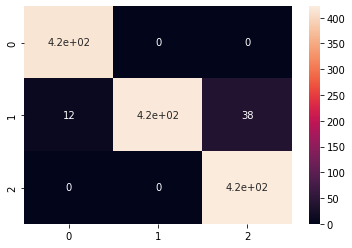

In [4]:
#Predicting quality with random forest
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=42)

pipe = Pipeline([('scaler',StandardScaler()),('RF',RandomForestClassifier(n_estimators=100))])
pipe.fit(X_train, y_train)
pipe.predict(X_test)

print('Accuracy Score : ')
print(accuracy_score(y_test,pipe.predict(X_test)))
print('*' * 120)
print('Confusion Matrix : ')
print(confusion_matrix(y_test,pipe.predict(X_test)))
print('*' * 120)
print('Classification Report : ')
print(classification_report(y_test, pipe.predict(X_test)))
print('*' * 120)
sns.heatmap(confusion_matrix(y_test,pipe.predict(X_test)), annot=True)

                 Feature  Importance
10               alcohol   14.983893
1       volatile acidity   14.438264
9              sulphates   13.534759
6   total sulfur dioxide    9.592182
2            citric acid    8.396506
8                     pH    7.502465
4              chlorides    7.248773
7                density    6.834727
5    free sulfur dioxide    6.371095
0          fixed acidity    5.590953
3         residual sugar    5.506383


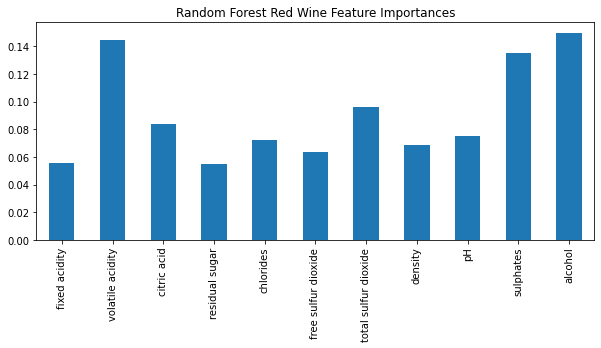

In [5]:
#Finding the importance of each from the random forest through mean decrease impurity
feature_names = [f"{i}" for i in wines_copy.columns[:-1]]
forest_importances = pd.Series(pipe[1].feature_importances_, index=feature_names)
featureImp= []

for feat, importance in zip(X_train.columns, pipe[1].feature_importances_):  
    temp = [feat, importance*100]
    featureImp.append(temp)

fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
print(fT_df.sort_values('Importance', ascending = False))

forest_importances.plot.bar(figsize = (10,4))
plt.title("Random Forest Red Wine Feature Importances")
plt.show()

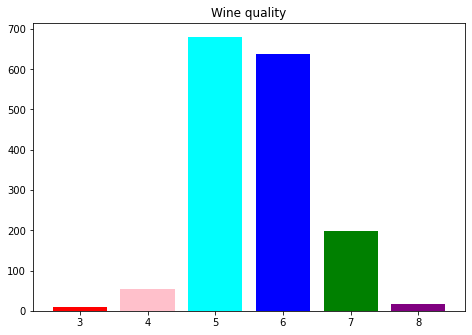

In [6]:
#Graph for distribution of wine quality
colors = ["red","pink","cyan","blue","green","purple"]

series = wines["quality"].value_counts()

sq = series.sort_index()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(sq.index,sq.values, color = colors)
ax.set_title("Wine quality")
plt.show()

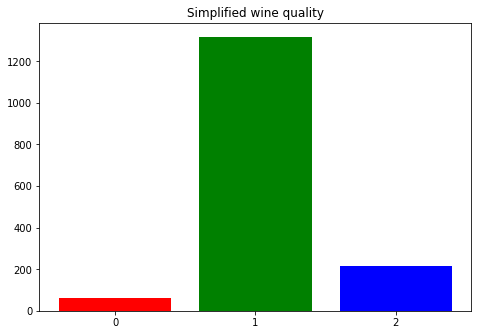

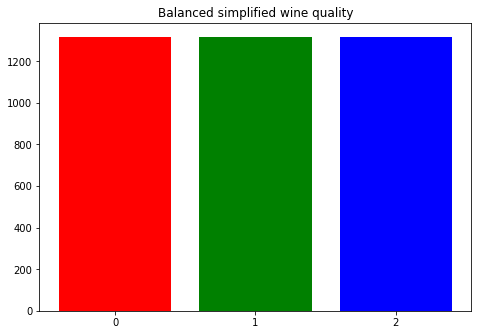

In [7]:
#Graph of simplified quality
colors1 = ["red","green","blue"]
series = wines_copy["simple_quality"].value_counts()
sq = series.sort_index()

fig = plt.figure()
qua = ["0","1","2"]
ax = fig.add_axes([0,0,1,1])
ax.bar(qua, sq.values, color = colors1)
ax.set_title("Simplified wine quality")

#Graph of balanced simplified quality
series = X_new["simple_quality"].value_counts()
sq = series.sort_index()

fig = plt.figure()
qua = ["0","1","2"]
ax = fig.add_axes([0,0,1,1])
ax.bar(qua, sq.values, color = colors1)
ax.set_title("Balanced simplified wine quality")
plt.show()

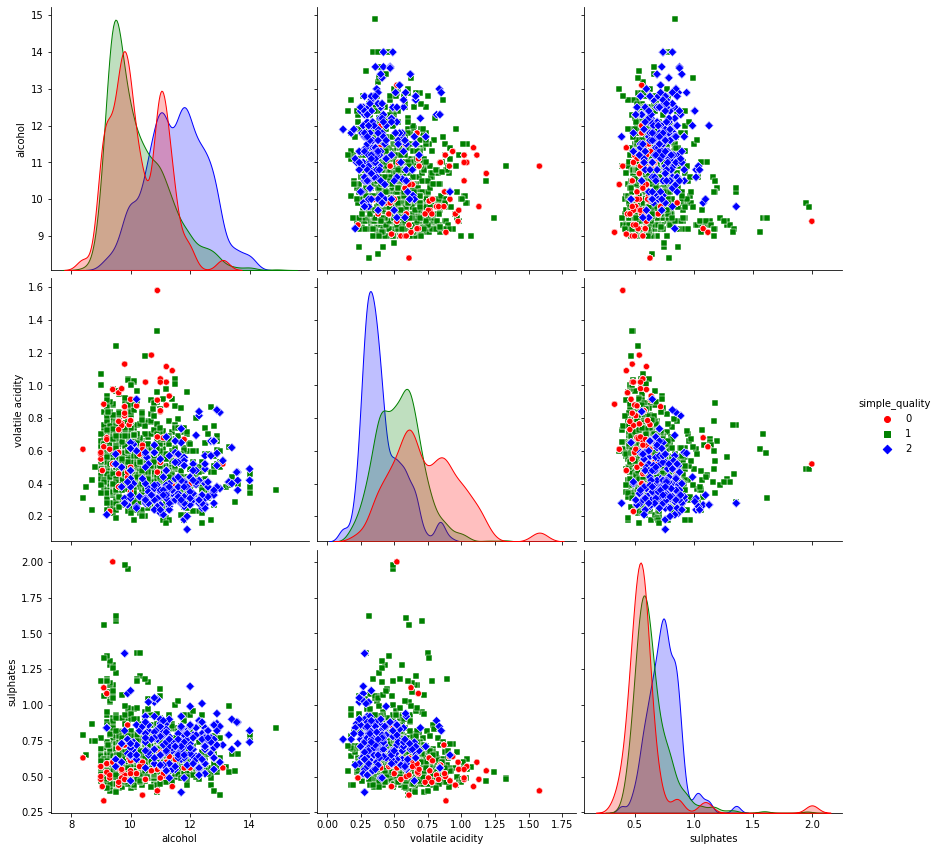

In [8]:
#Pairplot of the 3 most influencial classes
sns.pairplot(X_new[["alcohol","volatile acidity","sulphates", "simple_quality"]], hue = "simple_quality", palette = colors1, height = 4, markers = ["o","s","D"])
plt.show()